# YOLO V8

In [1]:
# Importaciones necesarias
import os
import json
import shutil
from pathlib import Path
import torch
import time
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def preparar_dataset_yolo(json_dir, image_dir, output_dir):
    """
    Crea la estructura de directorios para YOLOv8 y copia las imágenes.
    Ahora ignora una lista específica de archivos corruptos.
    """
    print("🚀 Iniciando preparación del dataset para YOLOv8...")
    output_path = Path(output_dir)

    # Lista de archivos a ignorar
    corrupt_images = {
        'VizWiz_v2_000000036425.png',
        'VizWiz_v2_000000040791.png'
    }

    # Limpiar directorio si existe para un inicio limpio
    if output_path.exists():
        shutil.rmtree(output_path)

    # Procesar cada split (train, val, test)
    for split in ['train', 'val', 'test']:
        json_path = Path(json_dir) / f'{split}.json'
        if not json_path.exists():
            print(f"⚠️ Archivo {json_path} no encontrado. Omitiendo split.")
            continue

        with open(json_path, 'r') as f:
            annotations = json.load(f)

        print(f"📁 Procesando {split}...")
        for ann in annotations:
            # Construir nombre de archivo .png
            base_name, _ = os.path.splitext(ann['image'])
            image_filename_png = f'{base_name}.png'

            # Omitir si la imagen está en la lista de corruptas
            if image_filename_png in corrupt_images:
                print(f"   -> Ignorando imagen corrupta conocida: {image_filename_png}")
                continue

            is_private = ann['private']
            label = 'private' if is_private == 1 else 'public'

            dst_folder = output_path / split / label
            dst_folder.mkdir(parents=True, exist_ok=True)

            src_path = Path(image_dir) / image_filename_png

            if src_path.exists():
                
                
                # NUEVA VALIDACIÓN: Verificar que la imagen no esté corrupta
                try:
                    
                    from PIL import Image
                    with Image.open(src_path) as img:
                        img.verify()  # Verificar integridad
                    shutil.copy(src_path, dst_folder)
                    print(f"   ✅ Copiada: {image_filename_png}")
                except Exception as e:
                    
                    print(f"   ❌ Imagen corrupta ignorada: {image_filename_png} - Error: {e}")
            else:
                print(f"   ⚠️ Imagen no encontrada: {image_filename_png}")
                

    print("\n✅ Preparación del dataset completada.")
    return str(output_path)

# --- Ejecutar Preparación ---
JSON_DIR = '../Downloads/Annotations'#'./Annotations/'
IMAGE_DIR = '../Downloads/Filling_Images' #'./Filling_Images/'
YOLO_DATASET_DIR = './yolo_dataset'

dataset_path_for_yolo = preparar_dataset_yolo(JSON_DIR, IMAGE_DIR, YOLO_DATASET_DIR)

🚀 Iniciando preparación del dataset para YOLOv8...
📁 Procesando train...
   ✅ Copiada: VizWiz_v2_000000031173.png
   ✅ Copiada: VizWiz_v2_000000031174.png
   ✅ Copiada: VizWiz_v2_000000031175.png
   ✅ Copiada: VizWiz_v2_000000031176.png
   ✅ Copiada: VizWiz_v2_000000031177.png
   ✅ Copiada: VizWiz_v2_000000031178.png
   ✅ Copiada: VizWiz_v2_000000031179.png
   ✅ Copiada: VizWiz_v2_000000031180.png
   ✅ Copiada: VizWiz_v2_000000031181.png
   ✅ Copiada: VizWiz_v2_000000031182.png
   ✅ Copiada: VizWiz_v2_000000031183.png
   ✅ Copiada: VizWiz_v2_000000031184.png
   ✅ Copiada: VizWiz_v2_000000031185.png
   ✅ Copiada: VizWiz_v2_000000031186.png
   ✅ Copiada: VizWiz_v2_000000031187.png
   ✅ Copiada: VizWiz_v2_000000031188.png
   ✅ Copiada: VizWiz_v2_000000031189.png
   ✅ Copiada: VizWiz_v2_000000031190.png
   ✅ Copiada: VizWiz_v2_000000031191.png
   ✅ Copiada: VizWiz_v2_000000031192.png
   ✅ Copiada: VizWiz_v2_000000031193.png
   ✅ Copiada: VizWiz_v2_000000031194.png
   ✅ Copiada: VizWiz_v2_0

In [3]:
print("\n🏋️ Iniciando entrenamiento de YOLOv8 para clasificación...")
model = YOLO('yolov8n-cls.pt') #  'yolov8n-cls.pt' \ 'yolov8s-cls.pt'
start_time = time.time()

results = model.train(
    data=dataset_path_for_yolo,
    epochs=100,  # Cambiar de 50 a 100
    imgsz=224,
    batch=16,  # Cambiar de 32 a 16 para mejor estabilidad
    patience=20,  # Cambiar de 15 a 20
    device='mps' if torch.backends.mps.is_available() else 'cpu',
    project='Privacy_Classification_Project',
    name='YOLOv8n_cls_run_optimized',  # Nuevo nombre
    exist_ok=True,
    pretrained=True,
    verbose=True,
    optimizer='AdamW',
    lr0=0.001,  # Volver a 0.001 para mejor convergencia
    lrf=0.01,  # NUEVO: Learning rate final
    momentum=0.937,  # NUEVO: Momentum
    weight_decay=0.0005,  # NUEVO: Weight decay
    warmup_epochs=3,  # NUEVO: Warmup epochs
    plots=True,  # Cambiar a True para generar plots
    save=True,
    augment=True,
    # NUEVOS PARÁMETROS DE AUGMENTACIÓN:
    hsv_h=0.015,  # Hue augmentation
    hsv_s=0.7,    # Saturation augmentation
    hsv_v=0.4,    # Value augmentation
    degrees=0.5,  # Rotation augmentation
    translate=0.1, # Translation augmentation
    scale=0.5,    # Scale augmentation
    shear=0.5,    # Shear augmentation
    perspective=0.0, # Perspective augmentation
    flipud=0.0,   # Vertical flip
    fliplr=0.5,   # Horizontal flip
    mosaic=1.0,   # Mosaic augmentation
    mixup=0.0,    # Mixup augmentation
)

training_time = time.time() - start_time
print(f"\n✅ Entrenamiento completado en {int(training_time//3600)}h {int((training_time%3600)//60)}m {int(training_time%60)}s")
best_model_path = Path(results.save_dir) / 'weights' / 'best.pt'
print(f"📁 Mejor modelo guardado en: {best_model_path}")


🏋️ Iniciando entrenamiento de YOLOv8 para clasificación...


100%|██████████████████████████████████████| 5.31M/5.31M [00:00<00:00, 21.3MB/s]


Ultralytics 8.3.156 🚀 Python-3.10.18 torch-2.7.1 MPS (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset, degrees=0.5, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8n_cls_run_optimized, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

train: Scanning /Users/jenniferintriago/script-YOLO/yolo_dataset/train... 8789 i


train: New cache created: /Users/jenniferintriago/script-YOLO/yolo_dataset/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2635.4±139.8 MB/s, size: 7225.7 KB)


val: Scanning /Users/jenniferintriago/script-YOLO/yolo_dataset/val... 1370 image

val: New cache created: /Users/jenniferintriago/script-YOLO/yolo_dataset/val.cache
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to Privacy_Classification_Project/YOLOv8n_cls_run_optimized
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size



      1/100      1.15G     0.6089          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.723          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.14G     0.5659          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:41<00:0

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.15G     0.5386          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:43<00:0

                   all       0.77          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.15G      0.523          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all       0.78          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.14G     0.4954          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.788          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.16G     0.4747          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.804          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.14G     0.4593          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.801          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.15G     0.4429          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.804          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.14G     0.4314          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.791          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.15G      0.426          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.819          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.14G     0.4031          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.801          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.16G     0.4137          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.836          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.14G     0.3919          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.801          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.15G      0.377          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.825          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.14G      0.373          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.827          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.15G     0.3645          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.809          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.14G     0.3506          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.813          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.15G     0.3533          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.836          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      1.14G     0.3421          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.815          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.15G     0.3377          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.828          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      1.14G     0.3343          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:41<00:0

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.15G     0.3268          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.826          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.16G      0.323          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.839          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.15G     0.3059          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.836          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.14G     0.3122          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.841          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.15G     0.2944          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.826          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.14G     0.2891          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:43<00:0

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.16G     0.2956          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.836          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.14G     0.2809          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.841          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.15G      0.281          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:44<00:0

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.16G     0.2677          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all       0.85          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.15G     0.2681          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.14G     0.2536          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.16G     0.2523          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:45<00:0

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      1.16G     0.2523          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.838          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.16G     0.2508          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:43<00:0

                   all       0.85          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.16G     0.2377          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.839          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.15G     0.2318          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:44<00:0

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.14G     0.2388          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.847          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.15G     0.2326          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.14G     0.2304          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all       0.85          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.15G     0.2201          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:43<00:0

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.14G     0.2197          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.845          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.15G     0.2182          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.851          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.14G     0.2131          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:43<00:0

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100      1.15G     0.2094          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.857          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100      1.14G     0.2079          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.847          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      1.15G     0.1947          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.854          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100      1.16G     0.2079          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.852          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100      1.15G     0.1949          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100      1.14G     0.1966          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100      1.15G     0.1933          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all       0.85          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100      1.14G     0.1773          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100      1.15G     0.1781          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.856          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      1.16G     0.1834          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:43<00:0

                   all      0.847          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100      1.15G     0.1686          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:44<00:0

                   all      0.852          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100      1.16G     0.1683          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.861          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100      1.15G     0.1748          5        224: 100%|██████████| 550/55
               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0

                   all      0.848          1
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 38, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



58 epochs completed in 5.813 hours.
Optimizer stripped from Privacy_Classification_Project/YOLOv8n_cls_run_optimized/weights/last.pt, 3.0MB
Optimizer stripped from Privacy_Classification_Project/YOLOv8n_cls_run_optimized/weights/best.pt, 3.0MB

Validating Privacy_Classification_Project/YOLOv8n_cls_run_optimized/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.10.18 torch-2.7.1 MPS (Apple M1)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/jenniferintriago/script-YOLO/yolo_dataset/train... found 8789 images in 2 classes ✅ 
val: /Users/jenniferintriago/script-YOLO/yolo_dataset/val... found 1370 images in 2 classes ✅ 
test: /Users/jenniferintriago/script-YOLO/yolo_dataset/test... found 3402 images in 2 classes ✅ 


               classes   top1_acc   top5_acc:   0%|          | 0/43 [00:00<?, ?i

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:   2%|▏         | 1/43 [00:01<00:54

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:   5%|▍         | 2/43 [00:02<00:45

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:   7%|▋         | 3/43 [00:03<00:39

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:   9%|▉         | 4/43 [00:04<00:37

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  12%|█▏        | 5/43 [00:05<00:38

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  14%|█▍        | 6/43 [00:06<00:37

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  16%|█▋        | 7/43 [00:07<00:34

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  19%|█▊        | 8/43 [00:08<00:34

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  21%|██        | 9/43 [00:08<00:32

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  23%|██▎       | 10/43 [00:09<00:3

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  26%|██▌       | 11/43 [00:10<00:3

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  28%|██▊       | 12/43 [00:11<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  30%|███       | 13/43 [00:12<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  33%|███▎      | 14/43 [00:13<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  35%|███▍      | 15/43 [00:14<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  37%|███▋      | 16/43 [00:15<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  40%|███▉      | 17/43 [00:16<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  42%|████▏     | 18/43 [00:17<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  44%|████▍     | 19/43 [00:18<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  47%|████▋     | 20/43 [00:19<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  49%|████▉     | 21/43 [00:20<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  51%|█████     | 22/43 [00:21<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  53%|█████▎    | 23/43 [00:22<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  56%|█████▌    | 24/43 [00:24<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  58%|█████▊    | 25/43 [00:25<00:2

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  60%|██████    | 26/43 [00:26<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  63%|██████▎   | 27/43 [00:27<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  65%|██████▌   | 28/43 [00:28<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  67%|██████▋   | 29/43 [00:29<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  70%|██████▉   | 30/43 [00:30<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  72%|███████▏  | 31/43 [00:31<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  74%|███████▍  | 32/43 [00:32<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  77%|███████▋  | 33/43 [00:33<00:1

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  79%|███████▉  | 34/43 [00:34<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  81%|████████▏ | 35/43 [00:35<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  84%|████████▎ | 36/43 [00:36<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  86%|████████▌ | 37/43 [00:37<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  88%|████████▊ | 38/43 [00:38<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  91%|█████████ | 39/43 [00:39<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  93%|█████████▎| 40/43 [00:40<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  95%|█████████▌| 41/43 [00:41<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  98%|█████████▊| 42/43 [00:42<00:0

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc: 100%|██████████| 43/43 [00:42<00:0


                   all      0.861          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to Privacy_Classification_Project/YOLOv8n_cls_run_optimized

✅ Entrenamiento completado en 5h 50m 12s
📁 Mejor modelo guardado en: Privacy_Classification_Project/YOLOv8n_cls_run_optimized/weights/best.pt



🧪 Cargando el mejor modelo para evaluación en el conjunto de prueba...

--- 1. Evaluación Automática de YOLOv8 (CORREGIDA) ---
Ultralytics 8.3.156 🚀 Python-3.10.18 torch-2.7.1 CPU (Apple M1)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/jenniferintriago/script-YOLO/yolo_dataset/train... found 8789 images in 2 classes ✅ 
val: /Users/jenniferintriago/script-YOLO/yolo_dataset/val... found 1370 images in 2 classes ✅ 
test: /Users/jenniferintriago/script-YOLO/yolo_dataset/test... found 3402 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.6±1.2 ms, read: 1380.4±626.8 MB/s, size: 7225.7 KB)


val: Scanning /Users/jenniferintriago/script-YOLO/yolo_dataset/val... 1370 image
               classes   top1_acc   top5_acc: 100%|██████████| 86/86 [00:55<00:0


                   all      0.861          1
Speed: 0.0ms preprocess, 11.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val5

🎯 Accuracy (Automática) en Test Set: 86.13%


--- 2. Evaluación Manual Detallada ---

📁 Verificando estructura de carpetas:
   - private: 1394 imágenes
   - public: 2008 imágenes

Procesando 1394 imágenes de la clase 'private'...

Procesando 2008 imágenes de la clase 'public'...

✅ Total de imágenes evaluadas: 3402

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

     private       0.72      0.85      0.78      1394
      public       0.88      0.76      0.82      2008

    accuracy                           0.80      3402
   macro avg       0.80      0.81      0.80      3402
weighted avg       0.81      0.80      0.80      3402


📊 MATRIZ DE CONFUSIÓN:
✅ Matriz de confusión guardada en: resultados_evaluacion/confusion_matrix.png


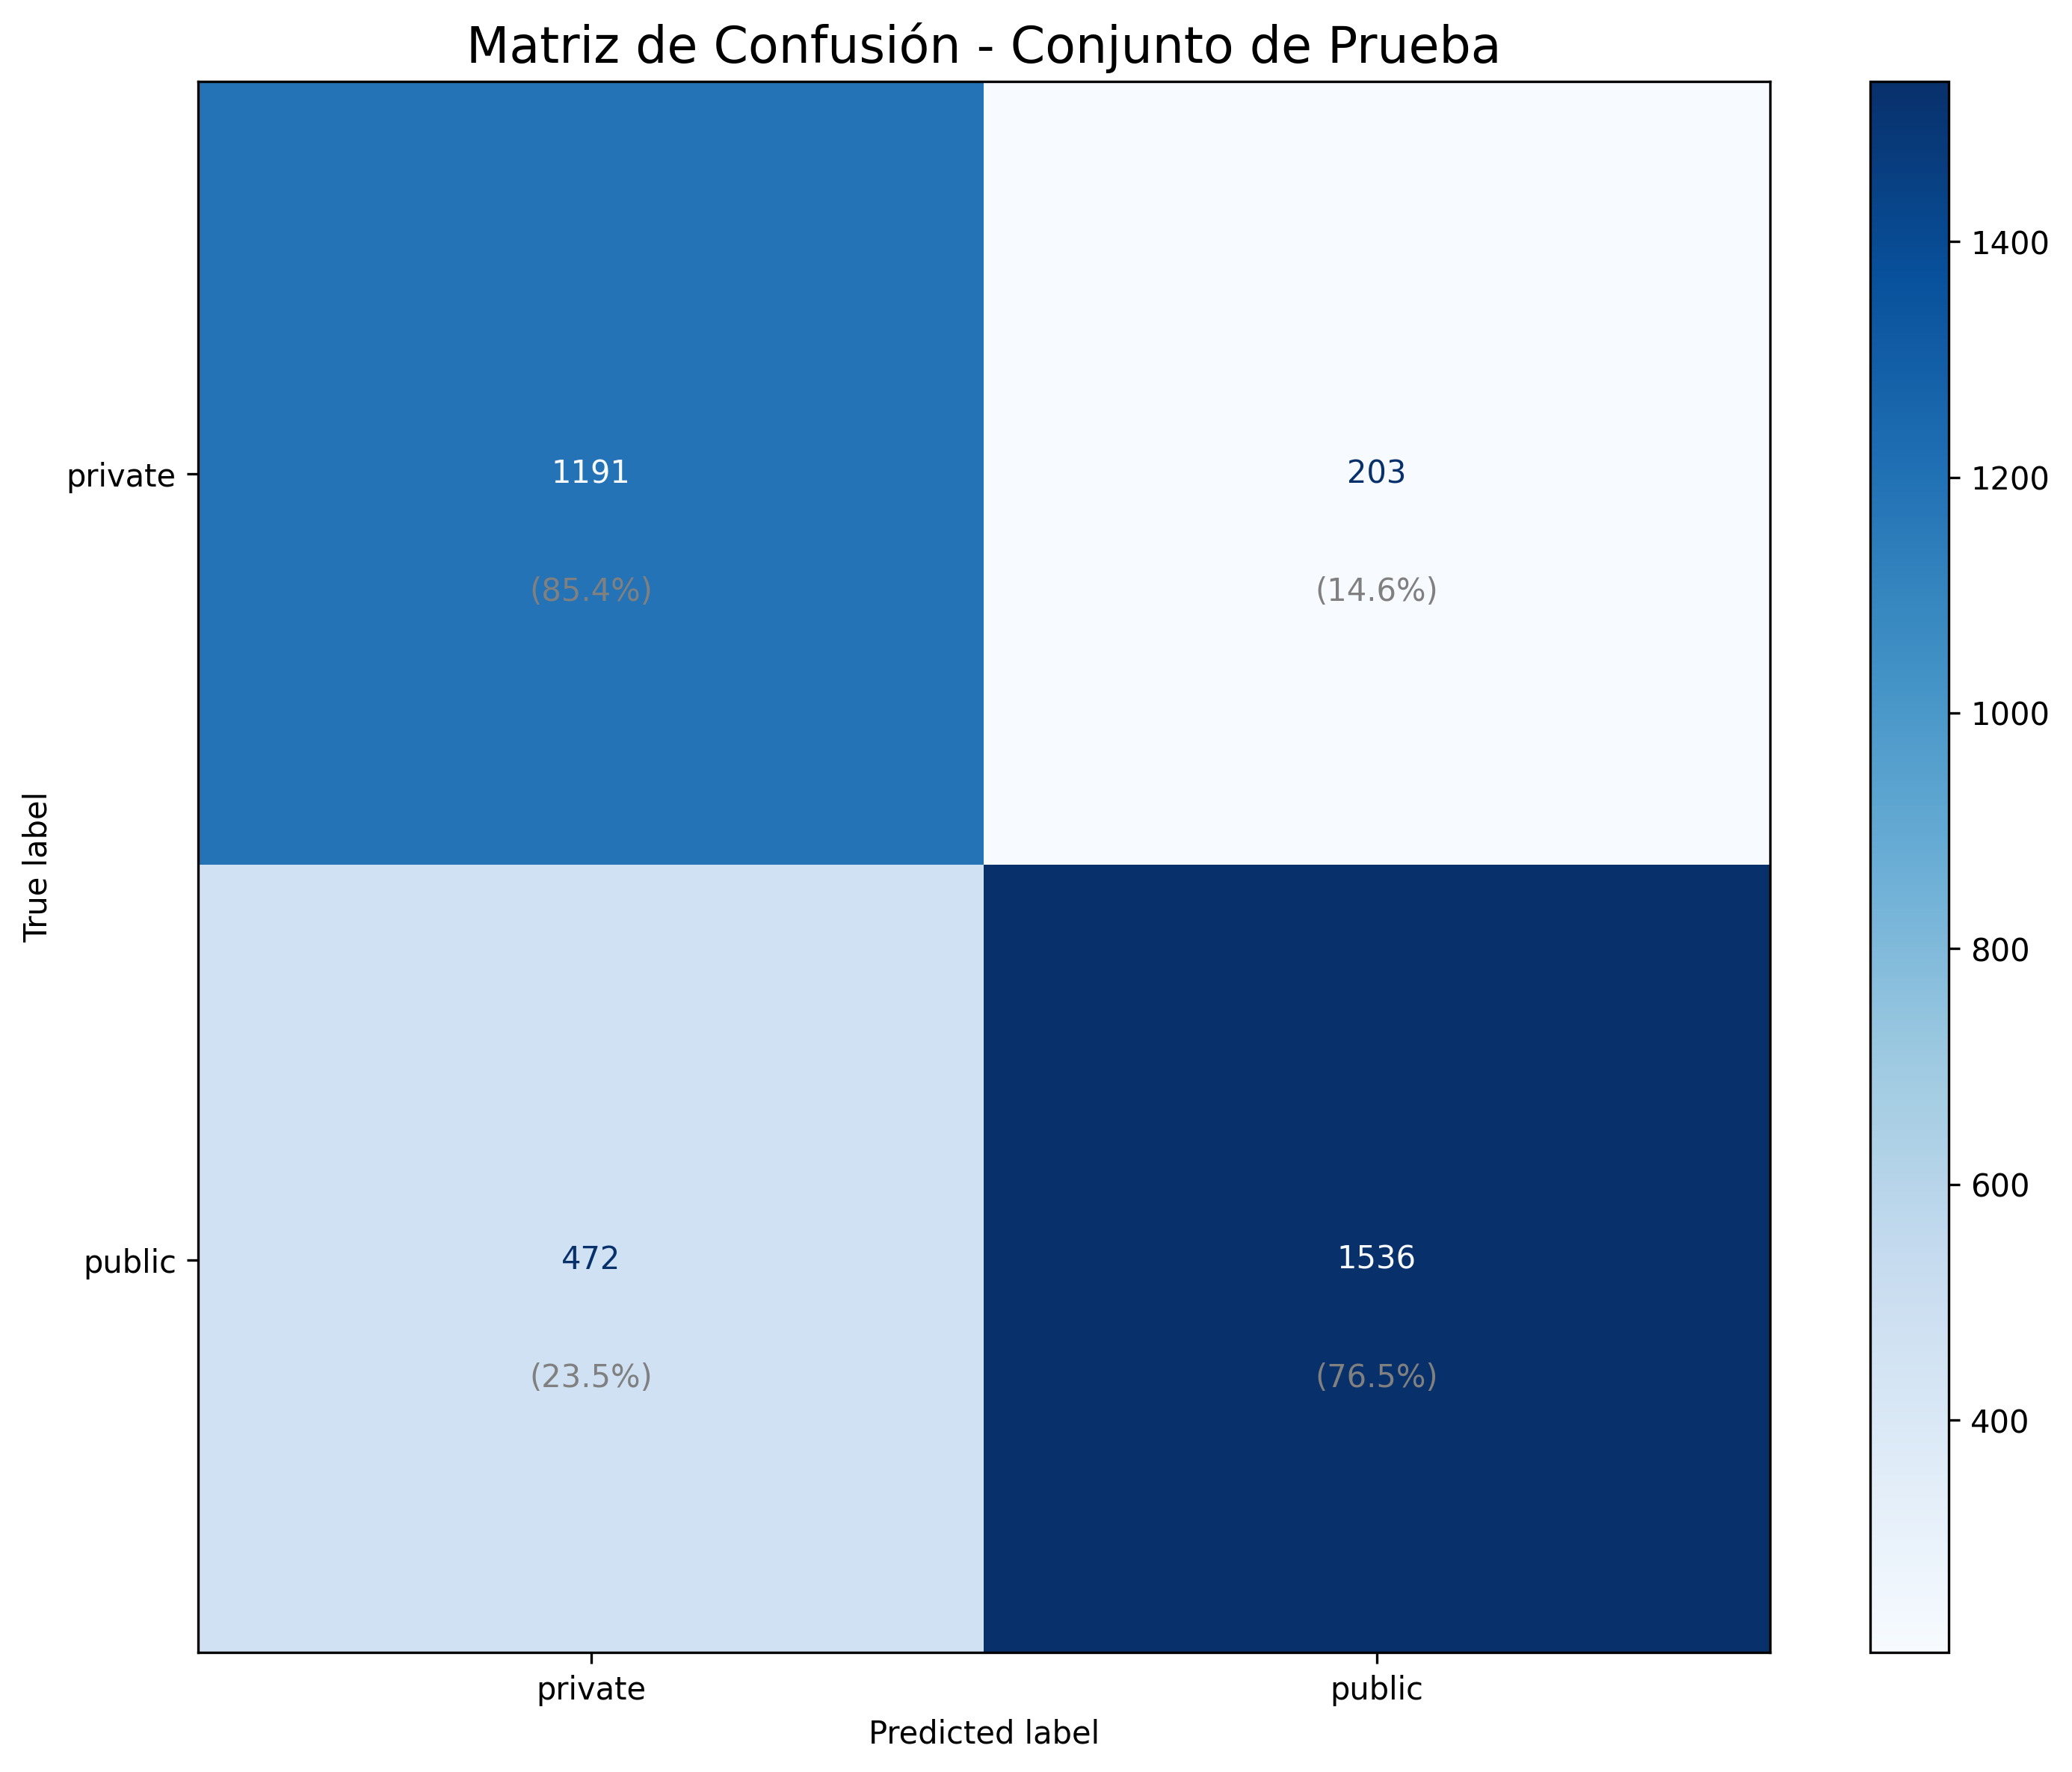


📈 CURVA ROC Y ÁREA BAJO LA CURVA (AUC):
   -> Área Bajo la Curva (AUC): 0.8993
✅ Curva ROC guardada en: resultados_evaluacion/roc_curve.png


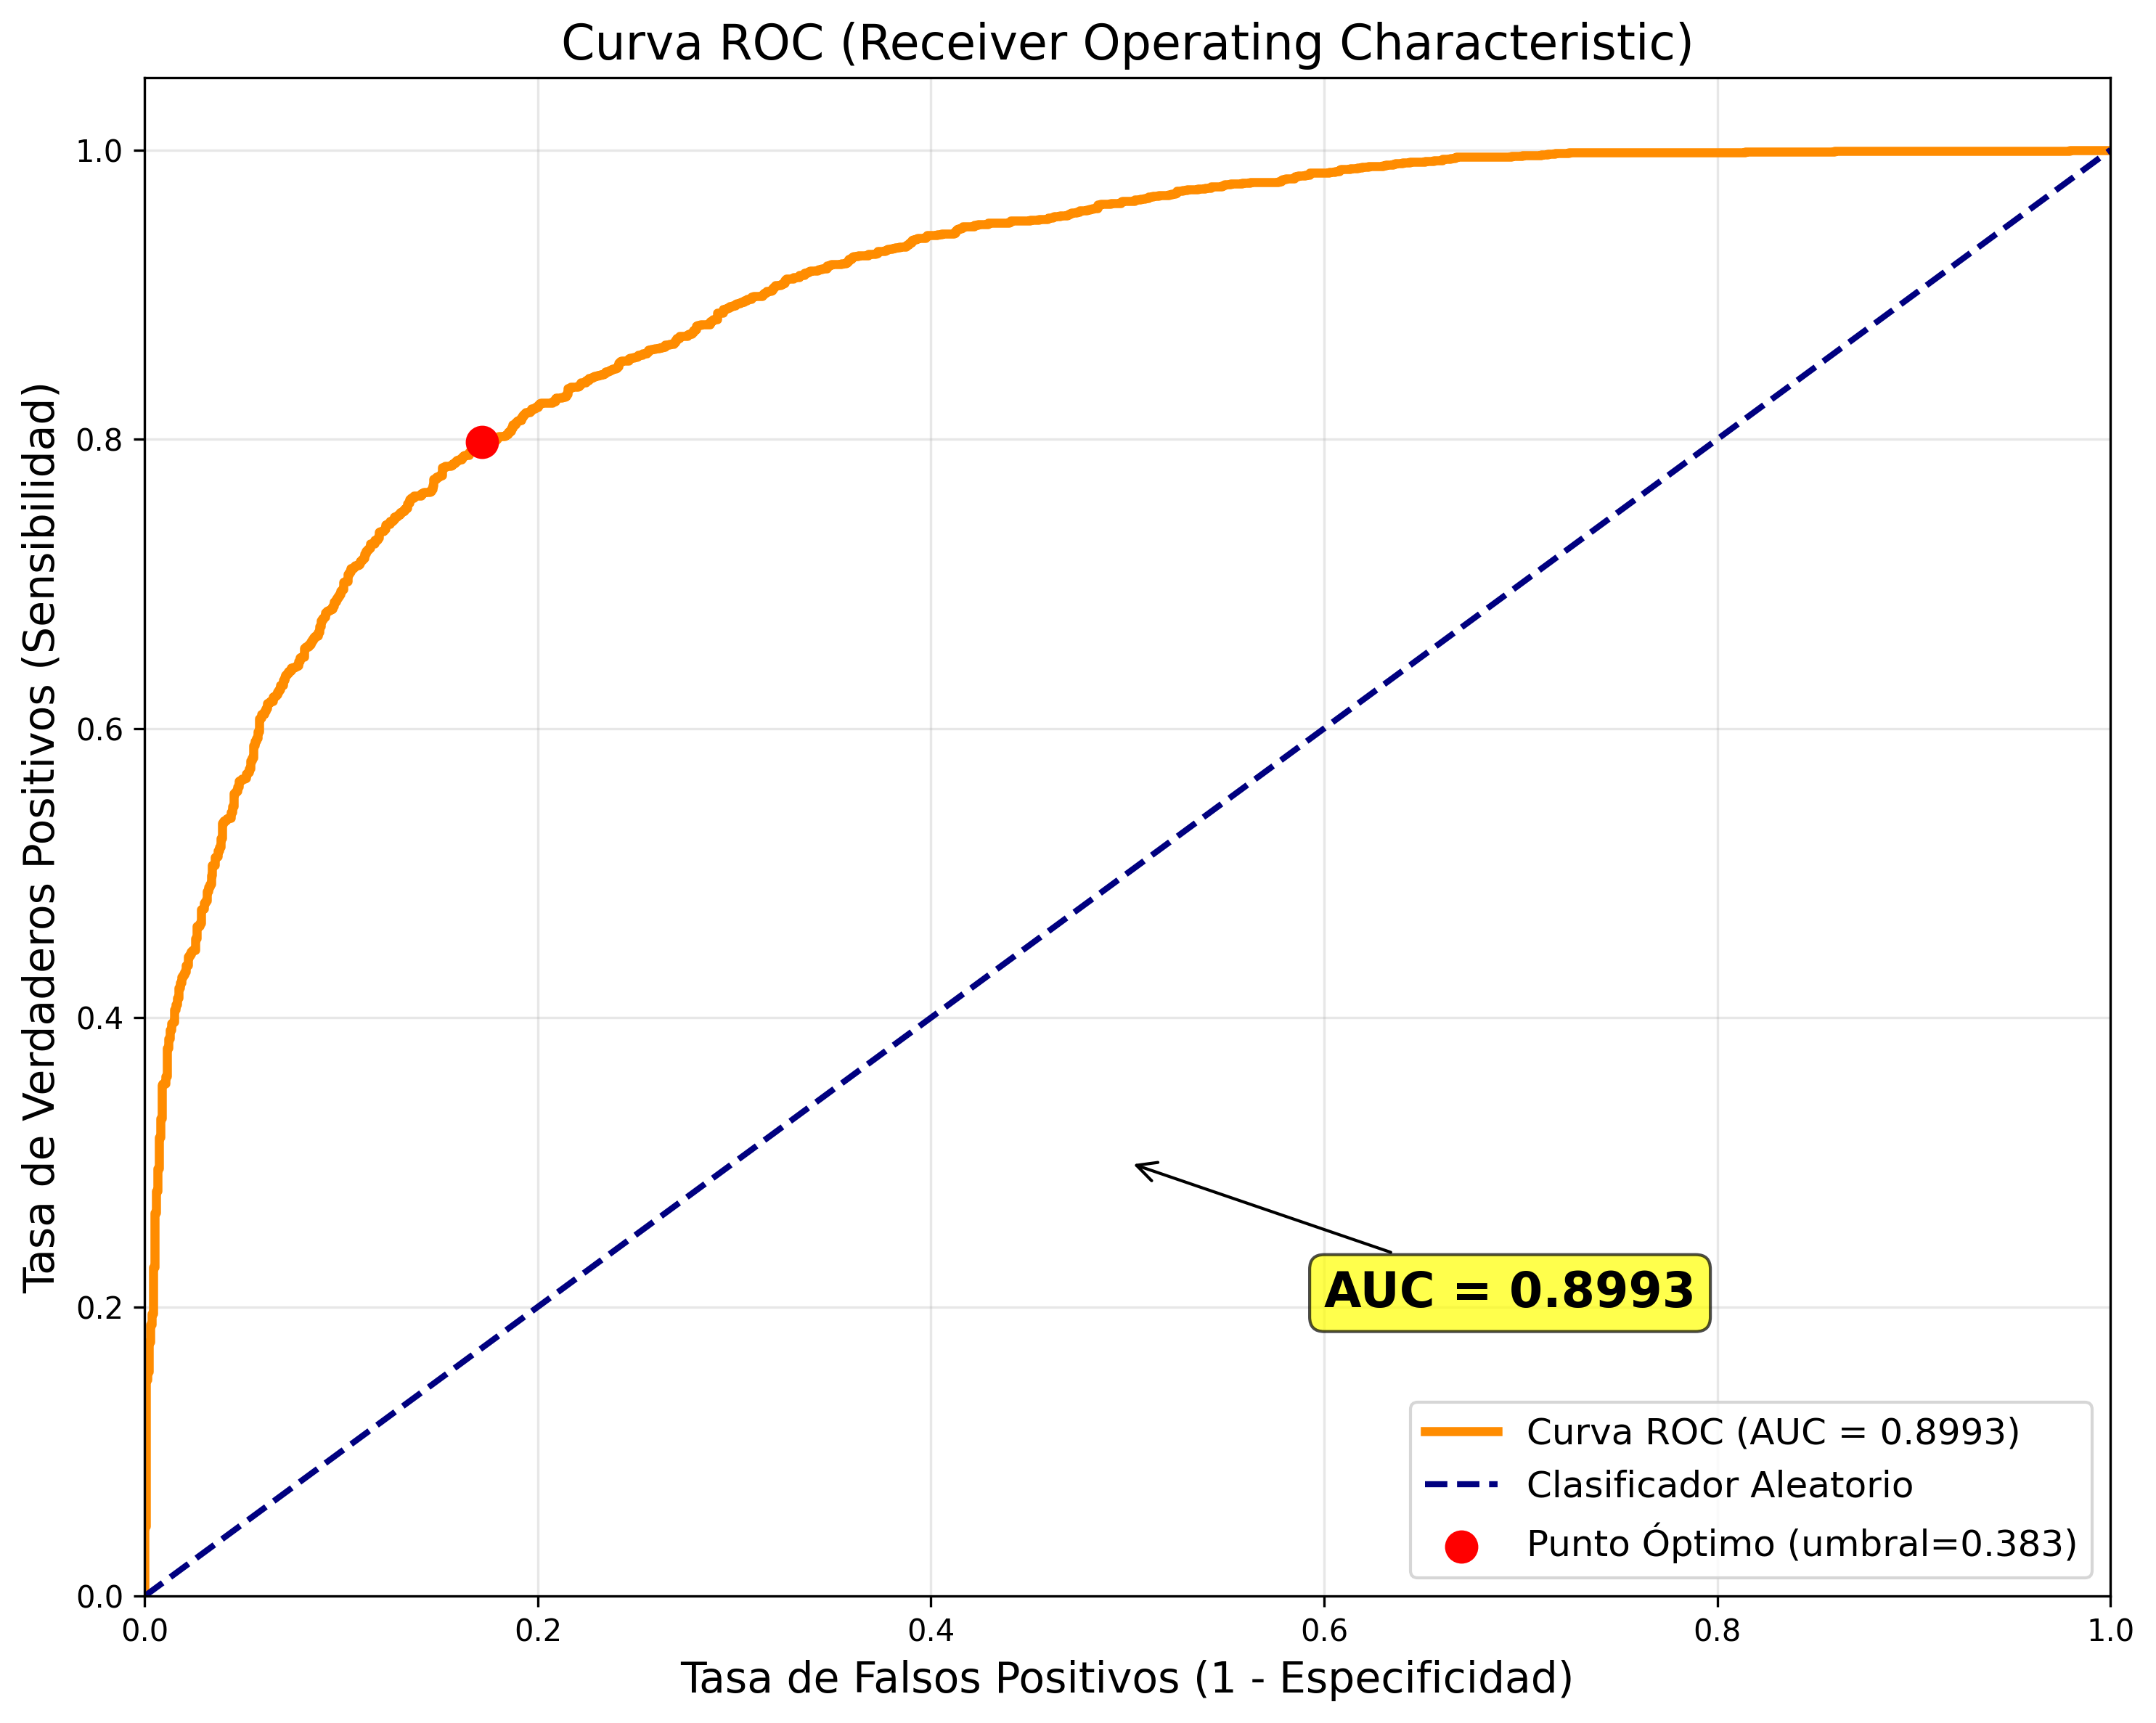


🔍 ANÁLISIS DE ERRORES:

PRIVATE:
  • Precision: 0.716
  • Recall: 0.854
  • F1-Score: 0.779
  • Support: 1394

PUBLIC:
  • Precision: 0.883
  • Recall: 0.765
  • F1-Score: 0.820
  • Support: 2008


📊 RESUMEN FINAL DE EVALUACIÓN:
• Total de imágenes evaluadas: 3402
• Accuracy global: 86.13%
• AUC-ROC: 0.8993
• Umbral óptimo: 0.383

• Distribución de clases en test:
  - private: 1394 (41.0%)
  - public: 2008 (59.0%)

✅ Todos los resultados guardados en: resultados_evaluacion


In [21]:
### Celda 4 CORREGIDA: Evaluación con Configuración Correcta
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from IPython.display import display, Image
from pathlib import Path
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

# Crear directorio para guardar las gráficas
output_dir = Path('./resultados_evaluacion')
output_dir.mkdir(exist_ok=True)

if 'best_model_path' in locals() and best_model_path.exists():
    print("\n🧪 Cargando el mejor modelo para evaluación en el conjunto de prueba...")
    model = YOLO(best_model_path)
    
    # CORRECCIÓN: Usar la ruta completa del dataset y especificar el yaml correcto
    yaml_path = Path(dataset_path_for_yolo) / 'dataset.yaml'
    
    # --- 1. Evaluación Automática CORREGIDA ---
    print("\n--- 1. Evaluación Automática de YOLOv8 (CORREGIDA) ---")
    
    # Opción 1: Si tienes el archivo dataset.yaml
    if yaml_path.exists():
        metrics = model.val(data=str(yaml_path), split='test', plots=True)
    else:
        # Opción 2: Evaluación directa en la carpeta test
        test_dir = Path(dataset_path_for_yolo) / 'test'
        metrics = model.val(source=str(test_dir), plots=True)
    
    accuracy_auto = metrics.results_dict.get('metrics/accuracy_top1', 0)
    print(f"\n🎯 Accuracy (Automática) en Test Set: {accuracy_auto * 100:.2f}%")
    
    # --- 2. Evaluación Manual Detallada ---
    print("\n\n--- 2. Evaluación Manual Detallada ---")
    
    test_dir = Path(dataset_path_for_yolo) / 'test'
    y_true = []
    y_pred_class = []
    y_pred_scores = []
    class_names_dict = model.names 
    class_labels_list = list(class_names_dict.values())
    
    # Verificar estructura de carpetas
    print("\n📁 Verificando estructura de carpetas:")
    for class_name in class_labels_list:
        class_dir = test_dir / class_name
        if class_dir.exists():
            n_images = len(list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg')))
            print(f"   - {class_name}: {n_images} imágenes")
        else:
            print(f"   - {class_name}: ❌ Carpeta no encontrada")
    
    # Procesar imágenes por clase
    for class_index, class_name in class_names_dict.items():
        class_dir = test_dir / class_name
        images = list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpg'))
        
        if not images:
            continue
        print(f"\nProcesando {len(images)} imágenes de la clase '{class_name}'...")
        
        # Procesar en lotes pequeños para evitar problemas de memoria
        batch_size = 32
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i+batch_size]
            results_pred = model(batch_images, verbose=False)
            
            for res in results_pred:
                y_true.append(class_index)
                y_pred_class.append(res.probs.top1)
                y_pred_scores.append(res.probs.data[1].item() if len(res.probs.data) > 1 else 0)
    
    # Verificar que tenemos predicciones
    if not y_true:
        print("❌ No se procesaron imágenes. Verifica la estructura de carpetas.")
        exit()
    
    print(f"\n✅ Total de imágenes evaluadas: {len(y_true)}")
    
    # --- 2a. Reporte de Clasificación ---
    print("\n📋 REPORTE DE CLASIFICACIÓN:")
    print("="*50)
    report = classification_report(y_true, y_pred_class, target_names=class_labels_list)
    print(report)
    
    # Guardar reporte
    with open(output_dir / 'classification_report.txt', 'w') as f:
        f.write("REPORTE DE CLASIFICACIÓN\n")
        f.write("="*50 + "\n")
        f.write(report)
    
    # --- 2b. Matriz de Confusión ---
    print("\n📊 MATRIZ DE CONFUSIÓN:")
    cm = confusion_matrix(y_true, y_pred_class)
    
    fig_cm, ax_cm = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_list)
    disp.plot(ax=ax_cm, cmap=plt.cm.Blues, values_format='d')
    plt.title("Matriz de Confusión - Conjunto de Prueba", fontsize=16)
    
    # Añadir porcentajes
    for i in range(len(class_labels_list)):
        for j in range(len(class_labels_list)):
            percentage = cm[i, j] / cm[i].sum() * 100
            ax_cm.text(j, i + 0.15, f'({percentage:.1f}%)', 
                      ha='center', va='center', fontsize=10, color='gray')
    
    plt.tight_layout()
    cm_path = output_dir / 'confusion_matrix.png'
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Matriz de confusión guardada en: {cm_path}")
    display(Image(cm_path))
    
    # --- 2c. Curva ROC/AUC ---
    print("\n📈 CURVA ROC Y ÁREA BAJO LA CURVA (AUC):")
    
    # Solo calcular si es clasificación binaria
    if len(class_labels_list) == 2:
        auc_score = roc_auc_score(y_true, y_pred_scores)
        print(f"   -> Área Bajo la Curva (AUC): {auc_score:.4f}")
        
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores)
        
        # Punto óptimo
        optimal_idx = np.sqrt(np.square(1 - tpr) + np.square(fpr)).argmin()
        optimal_threshold = thresholds[optimal_idx]
        optimal_fpr = fpr[optimal_idx]
        optimal_tpr = tpr[optimal_idx]
        
        # Graficar
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'Curva ROC (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
        plt.scatter(optimal_fpr, optimal_tpr, color='red', s=100, zorder=5, 
                    label=f'Punto Óptimo (umbral={optimal_threshold:.3f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=14)
        plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=14)
        plt.title('Curva ROC (Receiver Operating Characteristic)', fontsize=16)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Anotación
        plt.annotate(f'AUC = {auc_score:.4f}', 
                    xy=(0.5, 0.3), xytext=(0.6, 0.2),
                    fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"))
        
        plt.tight_layout()
        roc_path = output_dir / 'roc_curve.png'
        plt.savefig(roc_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Curva ROC guardada en: {roc_path}")
        display(Image(roc_path))
    
    # --- 3. Análisis de Errores ---
    print("\n🔍 ANÁLISIS DE ERRORES:")
    print("="*50)
    
    # Calcular métricas por clase
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred_class, average=None)
    
    for i, class_name in enumerate(class_labels_list):
        print(f"\n{class_name.upper()}:")
        print(f"  • Precision: {precision[i]:.3f}")
        print(f"  • Recall: {recall[i]:.3f}")
        print(f"  • F1-Score: {f1[i]:.3f}")
        print(f"  • Support: {support[i]}")
    
    # --- 4. Resumen Final ---
    print("\n\n📊 RESUMEN FINAL DE EVALUACIÓN:")
    print("="*50)
    print(f"• Total de imágenes evaluadas: {len(y_true)}")
    print(f"• Accuracy global: {accuracy_auto * 100:.2f}%")
    if len(class_labels_list) == 2:
        print(f"• AUC-ROC: {auc_score:.4f}")
        print(f"• Umbral óptimo: {optimal_threshold:.3f}")
    print(f"\n• Distribución de clases en test:")
    for class_name in class_labels_list:
        count = support[class_labels_list.index(class_name)]
        percentage = count / len(y_true) * 100
        print(f"  - {class_name}: {count} ({percentage:.1f}%)")
    
    # Guardar resumen
    with open(output_dir / 'resumen_evaluacion.txt', 'w') as f:
        f.write("RESUMEN FINAL DE EVALUACIÓN\n")
        f.write("="*50 + "\n")
        f.write(f"• Total de imágenes evaluadas: {len(y_true)}\n")
        f.write(f"• Accuracy global: {accuracy_auto * 100:.2f}%\n")
        if len(class_labels_list) == 2:
            f.write(f"• AUC-ROC: {auc_score:.4f}\n")
            f.write(f"• Umbral óptimo: {optimal_threshold:.3f}\n")
    
    print(f"\n✅ Todos los resultados guardados en: {output_dir}")
    
else:
    print(f"❌ No se encontró el archivo del modelo.")

📁 Cargando datos desde: Privacy_Classification_Project/YOLOv8n_cls_run_optimized/results.csv

📈 Gráficos de Pérdidas y Precisión guardados en Privacy_Classification_Project/YOLOv8n_cls_run_optimized/graficos_de_entrenamiento.png


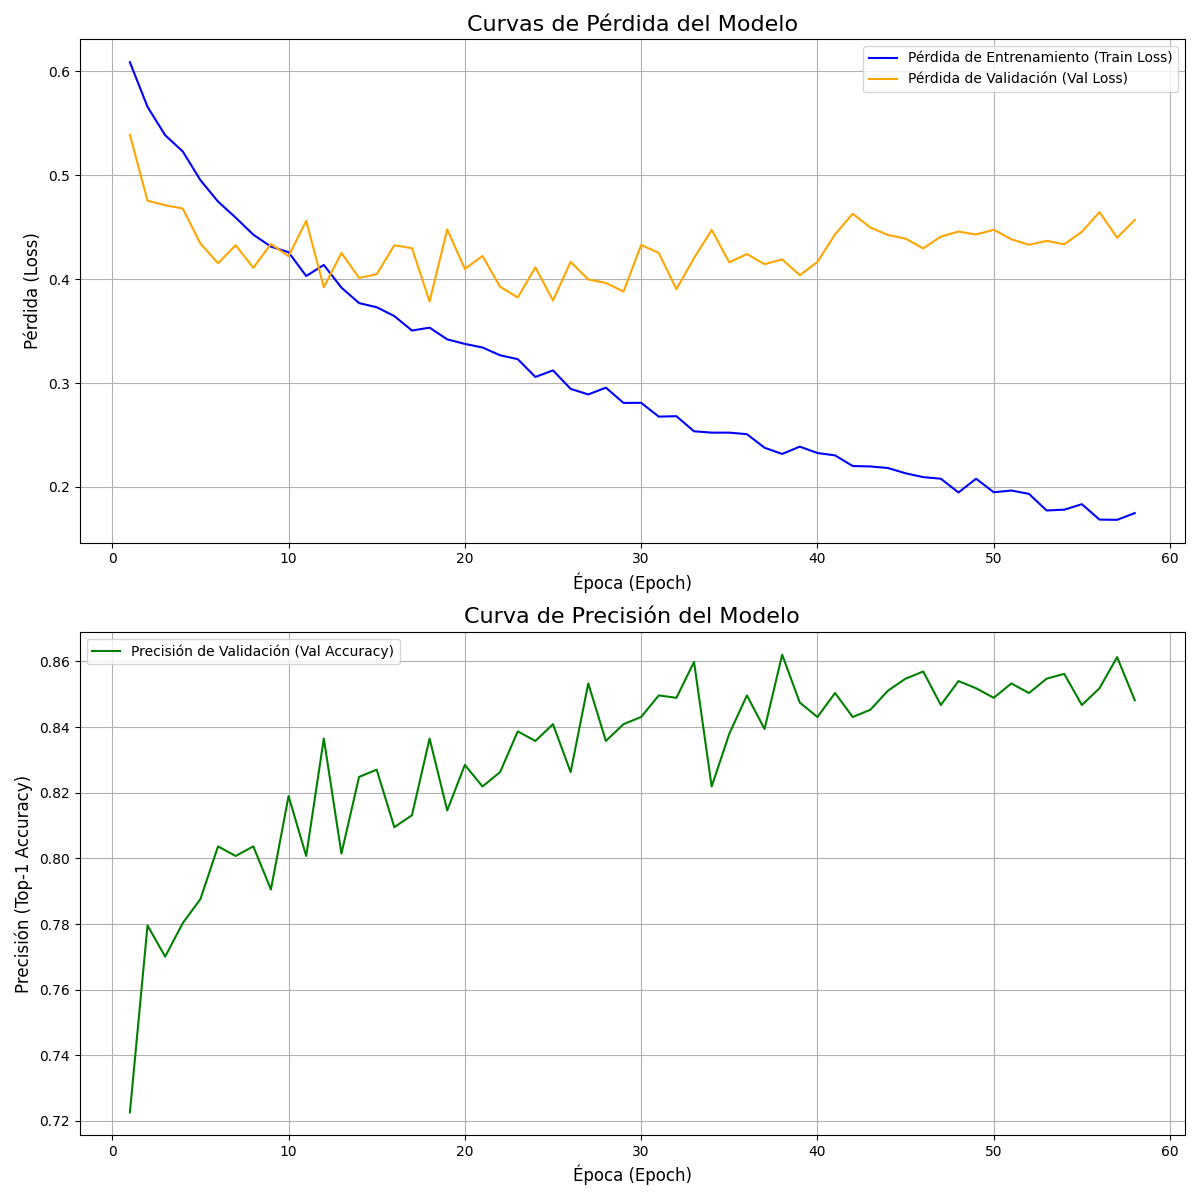

In [22]:
### Celda 5: Generación y Visualización de Gráficos (Versión Final y Robusta)

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image # <-- Importar las herramientas de visualización
from pathlib import Path

# La variable 'results' fue creada en la Celda 3 durante el entrenamiento.
if 'results' in locals():
    results_dir = Path(results.save_dir)
    results_path = results_dir / 'results.csv'

    print(f"📁 Cargando datos desde: {results_path}\n")

    if results_path.exists():
        # Cargar los datos del CSV en un DataFrame de pandas
        data = pd.read_csv(results_path)
        data.columns = data.columns.str.strip()

        # Crear una figura y un conjunto de subplots
        fig, ax = plt.subplots(2, 1, figsize=(12, 12))
        
        # --- Gráfico 1: Curvas de Pérdida (Loss) ---
        ax[0].plot(data['epoch'], data['train/loss'], label='Pérdida de Entrenamiento (Train Loss)', color='blue')
        ax[0].plot(data['epoch'], data['val/loss'], label='Pérdida de Validación (Val Loss)', color='orange')
        ax[0].set_title('Curvas de Pérdida del Modelo', fontsize=16)
        ax[0].set_xlabel('Época (Epoch)', fontsize=12)
        ax[0].set_ylabel('Pérdida (Loss)', fontsize=12)
        ax[0].legend()
        ax[0].grid(True)

        # --- Gráfico 2: Curvas de Precisión (Accuracy) ---
        ax[1].plot(data['epoch'], data['metrics/accuracy_top1'], label='Precisión de Validación (Val Accuracy)', color='green')
        ax[1].set_title('Curva de Precisión del Modelo', fontsize=16)
        ax[1].set_xlabel('Época (Epoch)', fontsize=12)
        ax[1].set_ylabel('Precisión (Top-1 Accuracy)', fontsize=12)
        ax[1].legend()
        ax[1].grid(True)
        
        plt.tight_layout()

        # --- CORRECCIÓN: Guardar la figura en un archivo y luego mostrarla ---
        plot_filename = results_dir / "graficos_de_entrenamiento.png"
        plt.savefig(plot_filename) # Guardar la figura
        plt.close(fig) # Cerrar la figura para liberar memoria

        print(f"📈 Gráficos de Pérdidas y Precisión guardados en {plot_filename}")
        display(Image(filename=plot_filename)) # Mostrar el archivo de imagen guardado

    else:
        print(f"❌ No se encontró el archivo 'results.csv' en la ruta: {results_path}")

else:
    print("⚠️ No se encontró la variable 'results' del entrenamiento.")
    print("Por favor, ejecuta la celda de entrenamiento (Celda 3) primero.")

In [20]:
### Celda 5: Predicción en Imágenes de Ejemplo
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image as PILImage
import numpy as np
from pathlib import Path
import random
from IPython.display import display, Image

# Crear directorio para guardar predicciones
predictions_dir = Path('./predicciones_ejemplo')
predictions_dir.mkdir(exist_ok=True)

if 'best_model_path' in locals() and best_model_path.exists():
    print("🔮 PREDICCIÓN EN IMÁGENES DE EJEMPLO")
    print("="*50)
    
    # Cargar el modelo si no está cargado
    if 'model' not in locals():
        model = YOLO(best_model_path)
    
    # Función para predecir y visualizar una imagen
    def predict_and_visualize(image_path, save_path=None):
        """
        Realiza predicción en una imagen y la visualiza con el resultado
        """
        # Realizar predicción
        results = model(image_path, verbose=False)
        result = results[0]
        
        # Obtener predicción y confianza
        predicted_class_id = result.probs.top1
        predicted_class_name = model.names[predicted_class_id]
        confidence = result.probs.top1conf.item()
        
        # Obtener todas las probabilidades
        all_probs = result.probs.data.cpu().numpy()
        
        # Cargar imagen para visualización
        img = PILImage.open(image_path)
        img_array = np.array(img)
        
        # Crear figura con subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Subplot 1: Imagen con predicción
        ax1.imshow(img_array)
        ax1.axis('off')
        
        # Determinar color según confianza
        if confidence > 0.9:
            color = 'green'
            emoji = '✅'
        elif confidence > 0.7:
            color = 'orange'
            emoji = '⚠️'
        else:
            color = 'red'
            emoji = '❌'
        
        # Título con predicción
        title = f"{emoji} Predicción: {predicted_class_name.upper()}\nConfianza: {confidence:.2%}"
        ax1.set_title(title, fontsize=16, fontweight='bold', color=color)
        
        # Añadir borde de color según la predicción
        rect = patches.Rectangle((0, 0), img_array.shape[1]-1, img_array.shape[0]-1,
                               linewidth=10, edgecolor=color, facecolor='none')
        ax1.add_patch(rect)
        
        # Subplot 2: Gráfico de barras con probabilidades
        ax2.bar(model.names.values(), all_probs, color=['#1f77b4', '#ff7f0e'])
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Probabilidad', fontsize=12)
        ax2.set_title('Distribución de Probabilidades', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        
        # Resaltar la clase predicha
        bars = ax2.patches
        bars[predicted_class_id].set_color(color)
        bars[predicted_class_id].set_edgecolor('black')
        bars[predicted_class_id].set_linewidth(2)
        
        # Añadir valores en las barras
        for i, (bar, prob) in enumerate(zip(bars, all_probs)):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        
        # Guardar si se especifica
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"   ✅ Predicción guardada en: {save_path}")
        
        plt.show()
        plt.close()
        
        # Retornar información de la predicción
        return {
            'image_path': str(image_path),
            'predicted_class': predicted_class_name,
            'confidence': confidence,
            'all_probabilities': {name: float(prob) for name, prob in zip(model.names.values(), all_probs)}
        }
    
    # --- OPCIÓN 1: Seleccionar imágenes aleatorias del conjunto de prueba ---
    print("\n📸 OPCIÓN 1: Predicciones en imágenes aleatorias del conjunto de prueba")
    print("-"*50)
    
    test_images = []
    for class_name in model.names.values():
        class_dir = Path(dataset_path_for_yolo) / 'test' / class_name
        if class_dir.exists():
            images = list(class_dir.glob('*.png'))
            if images:
                # Seleccionar 2 imágenes aleatorias de cada clase
                selected = random.sample(images, min(2, len(images)))
                test_images.extend(selected)
    
    # Mezclar las imágenes
    random.shuffle(test_images)
    
    # Predecir en las primeras 4 imágenes
    resultados_predicciones = []
    for i, img_path in enumerate(test_images[:4]):
        print(f"\n🔍 Predicción {i+1}:")
        print(f"   Imagen: {img_path.name}")
        print(f"   Clase real: {img_path.parent.name}")
        
        save_path = predictions_dir / f'prediccion_{i+1}.png'
        resultado = predict_and_visualize(img_path, save_path)
        resultados_predicciones.append(resultado)
        
        # Verificar si la predicción es correcta
        es_correcta = resultado['predicted_class'] == img_path.parent.name
        print(f"   Resultado: {'✅ CORRECTO' if es_correcta else '❌ INCORRECTO'}")
    
    # --- OPCIÓN 2: Cargar tus propias imágenes ---
    print("\n\n📸 OPCIÓN 2: Predicción en tus propias imágenes")
    print("-"*50)
    print("Para usar tus propias imágenes:")
    print("1. Coloca las imágenes en la carpeta './imagenes_propias/'")
    print("2. Ejecuta el siguiente código:\n")
    
    # Código de ejemplo para imágenes propias
    example_code = '''
# Crear carpeta si no existe
custom_images_dir = Path('./imagenes_propias')
custom_images_dir.mkdir(exist_ok=True)

# Buscar imágenes en la carpeta
custom_images = list(custom_images_dir.glob('*.png')) + list(custom_images_dir.glob('*.jpg'))

if custom_images:
    print(f"\\n🖼️ Encontradas {len(custom_images)} imágenes propias")
    for i, img_path in enumerate(custom_images):
        print(f"\\n🔍 Predicción en imagen propia {i+1}: {img_path.name}")
        save_path = predictions_dir / f'prediccion_propia_{i+1}.png'
        resultado = predict_and_visualize(img_path, save_path)
        print(f"   -> Predicción: {resultado['predicted_class']} ({resultado['confidence']:.2%})")
else:
    print("⚠️ No se encontraron imágenes en './imagenes_propias/'")
    '''
    
    print(example_code)
    
    # --- OPCIÓN 3: Predicción individual rápida ---
    print("\n\n📸 OPCIÓN 3: Función de predicción rápida")
    print("-"*50)
    
    def quick_predict(image_path):
        """Predicción rápida sin visualización elaborada"""
        results = model(image_path, verbose=False)
        result = results[0]
        
        predicted_class = model.names[result.probs.top1]
        confidence = result.probs.top1conf.item()
        
        # Mostrar imagen con resultado simple
        img = PILImage.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        
        color = 'green' if confidence > 0.8 else 'orange' if confidence > 0.6 else 'red'
        plt.title(f"{predicted_class.upper()} ({confidence:.1%})", 
                 fontsize=20, fontweight='bold', color=color, pad=20)
        
        plt.tight_layout()
        plt.show()
        
        return predicted_class, confidence
    
    print("Uso: clase, confianza = quick_predict('ruta/a/tu/imagen.png')")
    
    # --- Resumen de predicciones ---
    if resultados_predicciones:
        print("\n\n📊 RESUMEN DE PREDICCIONES")
        print("="*50)
        print(f"Total de predicciones: {len(resultados_predicciones)}")
        
        confianzas = [r['confidence'] for r in resultados_predicciones]
        print(f"Confianza promedio: {np.mean(confianzas):.2%}")
        print(f"Confianza mínima: {np.min(confianzas):.2%}")
        print(f"Confianza máxima: {np.max(confianzas):.2%}")
        
        print("\nDetalles por imagen:")
        for i, r in enumerate(resultados_predicciones):
            print(f"{i+1}. {Path(r['image_path']).name} -> {r['predicted_class']} ({r['confidence']:.2%})")
    
else:
    print("❌ No se encontró el modelo. Ejecuta primero el entrenamiento.")

🔮 PREDICCIÓN EN IMÁGENES DE EJEMPLO

📸 OPCIÓN 1: Predicciones en imágenes aleatorias del conjunto de prueba
--------------------------------------------------

🔍 Predicción 1:
   Imagen: VizWiz_v2_000000042343.png
   Clase real: private


/var/folders/_r/w591vvkd7jzd79wvy543f_0w0000gn/T/ipykernel_77856/2919158705.py:89: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_r/w591vvkd7jzd79wvy543f_0w0000gn/T/ipykernel_77856/2919158705.py:93: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


   ✅ Predicción guardada en: predicciones_ejemplo/prediccion_1.png
   Resultado: ✅ CORRECTO

🔍 Predicción 2:
   Imagen: VizWiz_v2_000000040381.png
   Clase real: public


/var/folders/_r/w591vvkd7jzd79wvy543f_0w0000gn/T/ipykernel_77856/2919158705.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


   ✅ Predicción guardada en: predicciones_ejemplo/prediccion_2.png
   Resultado: ✅ CORRECTO

🔍 Predicción 3:
   Imagen: VizWiz_v2_000000043999.png
   Clase real: private
   ✅ Predicción guardada en: predicciones_ejemplo/prediccion_3.png
   Resultado: ❌ INCORRECTO

🔍 Predicción 4:
   Imagen: VizWiz_v2_000000038474.png
   Clase real: public
   ✅ Predicción guardada en: predicciones_ejemplo/prediccion_4.png
   Resultado: ✅ CORRECTO


📸 OPCIÓN 2: Predicción en tus propias imágenes
--------------------------------------------------
Para usar tus propias imágenes:
1. Coloca las imágenes en la carpeta './imagenes_propias/'
2. Ejecuta el siguiente código:


# Crear carpeta si no existe
custom_images_dir = Path('./imagenes_propias')
custom_images_dir.mkdir(exist_ok=True)

# Buscar imágenes en la carpeta
custom_images = list(custom_images_dir.glob('*.png')) + list(custom_images_dir.glob('*.jpg'))

if custom_images:
    print(f"\n🖼️ Encontradas {len(custom_images)} imágenes propias")
    for i, i